<a href="https://colab.research.google.com/github/lamantinushka/StructuredCovariance/blob/master/SLANG_UQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget https://github.com/aaronpmishkin/SLANG/releases/download/v1.0.0/data.zip
!unzip data.zip -d data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

# SWAG for Uncertainty Quantification

In [0]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
torch.manual_seed(0)
np.random.seed(0)
device = 'cuda'

We define our model to be Bayesian from the beggining, do tha after SWAG training it was able to work both in MAP and Baeyesian modes

In [0]:
def fast_inverse(g, U, d):
    # g - n_features x batch_size 
    # U - n_features x max_rank
    # d - n_features
    # output  n_features x batch_size
    dInv = 1/d.view(-1, 1)
    I_k = torch.eye(U.shape[1], dtype=U.dtype, device=U.device)
    Kinv = I_k + U.t() @ (dInv * U)
    s1 = U.t() @  (dInv * g.view(-1, 1))
    s2, _ = torch.solve(s1.view(-1, 1), Kinv)
    return dInv.view(-1) * ( g - (U @ s2).view(-1))

def fast_sample(mu, U, d, rand_sample=True):
    # mu, d - n_features
    # U - n_features x max_rank
    # output - n_features
    dinv = 1 /(d.view(-1, 1)**(0.5))
    if rand_sample:
      eps = torch.randn_like(dinv, device=U.device)
    else:
      eps = torch.zeros_like(dinv, device=U.device)
    V = U * dinv
    M = (V.t() @ V)
    A = torch.cholesky(M)
    B = torch.cholesky(torch.eye(M.shape[0], device=U.device) + M)
    Ainv = torch.inverse(A)
    
    for _ in range(2):
      try:
        I_b = torch.eye(B.shape[0], device=U.device)
      except:
        pass
    C = Ainv.t() @ (B - I_b) @ Ainv
    Kinv = C+ M
    s1 = V.t() @ eps
    s2, _ = torch.solve(s1, Kinv)
    y = eps * dinv - V @ s2
    return y.view(-1) + mu
  
def sample_full(mu, Sigma):
    dist = torch.distributions.MultivariateNormal(mu, Sigma)
    y = dist.sample()
    return y

def orthogonalize(A):
    (Q, _) = torch.qr(A)
    return Q
  
def svd_thin_matrix(A):
    (e, V) = torch.symeig(A @ A.t(), eigenvectors=True)
    e[e < 0] = 1e-20
    Sigma = torch.sqrt(e)
    SigInv = 1/Sigma 
    SigInv[torch.isnan(SigInv)] = 0
    U = A.t() @ (V * SigInv)
    return U, Sigma, V

def fast_eig(model, max_rank=6, n_iter=4, L=None, beta = 0.9):
    n = model.U.shape[0]
    def f(x):
        U = model.U
        # ((1 - beta)UU^T + beta \hatG(\theta))@x
        # \hat G(\theta) = -F = -N / M \sum g_i g_i^T
        f_val = (1 - beta) * U @(U.t() @ x) - beta * (model.grads.t() @ (model.grads @ x)) * N / model.grads.shape[0]
        return f_val    
        
    if L is None:
        L = max_rank+2

    def nystrom(Q, anorm):
        anorm = .1e-6 * anorm * math.sqrt(1. * n)
        E = f(Q) + anorm * Q
        R = Q.t() @ E
        R = (R + R.t()) / 2
        for _ in range(2):
          try:
            R = torch.cholesky(R) # Cholesky
          except:
            pass
        (tmp, _) = torch.solve(E.t(), R) # Solve
        V, d, _ = svd_thin_matrix(tmp)
        d = d * d - anorm
        return d, V

    Q = 2*(torch.rand((n, L), device=model.U.device, dtype=torch.float)-0.5)
    for _ in range(max(0, n_iter-1)):
        Q = orthogonalize(f(Q))
    oldQ = Q
    Q = f(Q)
    anorm = torch.max(torch.norm(Q, dim=0)/torch.norm(oldQ, dim=0))
    Q = orthogonalize(Q)
      
    d, V = nystrom(Q, anorm)

    (_, idx) = torch.abs(d).sort()
    idx = idx[(L-max_rank):]
    return V[:, idx] *torch.sqrt(abs(d[idx]))
  
def make_optimization_step(model, x, y, params, alpha = None, beta = None):
    if beta is None:
        beta = params["beta"]
    lmbd = params["lambda"]
    n_samples = params["n_samples_train"]
    nll = model.nll_loss(x, y, require_grads = True, n_samples = n_samples)
    if alpha is None:
        alpha = params["alpha"]
    n_iter = params["n_iter"]
    max_rank = model.max_rank
    # diag of \hat G = -F = -N / M \sum g_i g_i^T
    hessian_diag = (model.grads ** 2).sum(0) * N / model.grads.shape[0]
    # \hat grad = - N/M \sum g_i
    grads = -model.grads.sum(axis = 0) * N / model.grads.shape[0]
    V = fast_eig(model, max_rank = max_rank, beta = beta, n_iter = n_iter)
    delta_d = (1 - beta)*(model.U**2).sum(dim = 1) + beta*hessian_diag - (V**2).sum(dim = 1)
    delta_d[delta_d < 0] = 0
    model.U = torch.nn.Parameter(V)
    model.d = torch.nn.Parameter((1 - beta)*model.d + beta*lmbd + delta_d)
    delta_mu = fast_inverse(grads + lmbd*model.mu, model.U, model.d)
    model.mu = torch.nn.Parameter(model.mu - alpha * delta_mu)
    return nll

def acc(model, X, Y, batch_size):
  error_rate = 0
  for idx in tqdm(range(0, len(Y), batch_size)):
    x = X[idx:idx + batch_size]
    y = Y[idx:idx + batch_size]
    preds = torch.zeros(10, x.shape[0], model.out_dim, device=model.U.device)
    logits = model(x)
    log_probs = logits.log_softmax(-1)
    error_rate += (y != torch.argmax(log_probs, -1)).sum()
  return (error_rate.float() / len(Y)).item()

In [0]:
class MNISTBnn(nn.Module):
    def __init__(self, inp_dim = 14, hidden_size = 10, out_dim = 2, max_rank = 8, device='cpu'):
        super(MNISTBnn, self).__init__()
        self.max_rank = max_rank
        self.out_dim = out_dim
        self.shapes = [(inp_dim + 1, hidden_size), 
                       (hidden_size + 1, hidden_size),
                       (hidden_size + 1, self.out_dim)]
        self.sizes = [sh[0]*sh[1] for sh in self.shapes]
        size = sum(self.sizes)

        self.W1 = torch.randn(*self.shapes[0], device=device) * np.sqrt(2 / self.shapes[0][0])
        self.W2 = torch.randn(*self.shapes[1], device=device) * np.sqrt(2 / self.shapes[1][0])
        self.W3 = torch.randn(*self.shapes[2], device=device) * np.sqrt(2 / self.shapes[2][0])
     
        self.mu = torch.nn.Parameter(torch.randn(size, device=device)) * np.sqrt(2 / self.shapes[1][0])
        self.U = torch.nn.Parameter(torch.randn(size, max_rank, device=device))  * np.sqrt(2 / self.shapes[1][0])
        self.d = torch.nn.Parameter(torch.ones(size, device=device))
        self.w = None
        self.frozen = False
        
    def _freeze(self):
        self.frozen = True
        
    def _defrost(self):
        self.frozen = False
        
    def forward(self, x, sample=False):
        self.sample(rand=sample)
        z = torch.cat([x, torch.ones(x.shape[0], 1, dtype = torch.float, device=x.device)], 
                      dim = -1) @ self.W1
        z = torch.cat([torch.relu(z), torch.ones(z.shape[0], 1, dtype = torch.float, device=x.device)], 
                      dim = -1) @ self.W2
        logits = torch.cat([torch.relu(z), torch.ones(z.shape[0], 1, dtype = torch.float, device=x.device)], 
                           dim = -1) @ self.W3
        return logits
      
    def sample(self, rand=True):
      w = fast_sample(self.mu, self.U, self.d, rand)
      self.W1 = w[:self.sizes[0]].view(*self.shapes[0])
      self.W2 = w[self.sizes[0]:-self.sizes[2]].view(*self.shapes[1])
      self.W3 = w[-self.sizes[2]:].view(*self.shapes[2])
        
          
    def nll_loss(self, x, y, require_grads = False, n_samples = 4):
        """ 
        x - tensor [batch_size x feature_size]
        y - one-hot-encoded tensor [batch_size x n_classes]
        """
        if not require_grads:
          logits = self(x)
          log_probs = logits.log_softmax(-1)  
          return -(log_probs * y).sum()/x.shape[0]

        grads = torch.zeros(n_samples, x.shape[0], self.mu.shape[0], device=x.device)
        preds = torch.zeros(n_samples, x.shape[0], self.out_dim, device=x.device)
        for i in range(n_samples):
            self.sample()
            
            z1 = torch.cat([x, torch.ones(x.shape[0], 1, dtype = torch.float, device=x.device)], dim = -1)
            y1 = z1 @ self.W1
            z2 = torch.cat([torch.relu(y1), torch.ones(y1.shape[0], 1, dtype = torch.float, device=x.device)], dim = -1)
            y2 = z2 @ self.W2
            z3 = torch.cat([torch.relu(y2), torch.ones(y2.shape[0], 1, dtype = torch.float, device=x.device)], dim = -1)
            logits = z3 @ self.W3
            preds[i] = logits.log_softmax(-1)
            # matrix of \grad_\theta_j log p(X_i | \theta_j)
            dnll_dlogits = y - logits.softmax(-1)
                
            dW3 = torch.einsum('ab,ac->abc', z3, dnll_dlogits)
            dz3 = dnll_dlogits @ self.W3.t()
            dy2 = dz3[:, :-1]
            dy2[y2 < 0] = 0
                
            dW2 = torch.einsum('ab,ac->abc', z2, dy2)
            dz2 = dy2 @ self.W2.t()
            dy1 = dz2[:, :-1]
            dy1[y1 < 0] = 0
                
            dW1 = torch.einsum('ab,ac->abc', z1, dy1)
            grads[i][:, :self.sizes[0]] = dW1.view(x.shape[0], -1)
            grads[i][:, self.sizes[0]:-self.sizes[2]] = dW2.view(x.shape[0], -1)
            grads[i][:, -self.sizes[2]:] = dW3.view(x.shape[0], -1)
        self.grads = grads.mean(0)
        log_probs = preds.mean(0)  
        return (-(log_probs * y).sum()/x.shape[0]).item()

In [0]:
from tqdm import tqdm_notebook as tqdm
def train(model, X, y, params):
    loss = []
    test_nll = []
    batch_size = params["batch_size"]
    n_batches = (X.shape[0] + batch_size - 1)//batch_size 
    t = 0
    alpha0 = params["alpha"]
    pow = params["pow"]
    eval_samples = params["n_samples_eval"]
    if pow is None:
        pow = 0.
    for epoch in tqdm(range(params["n_epoch"])):
        idxes = np.arange(X.shape[0])
        np.random.shuffle(idxes)
        for i in tqdm(range(n_batches)):
            idx_batch = idxes[i*batch_size: (1+i)*batch_size]
            x_batch, y_batch = X[idx_batch], y[idx_batch]
            alpha = alpha0 /(1 + t**pow)
            beta = alpha
            nll = make_optimization_step(model, x_batch, y_batch, params, alpha = alpha, beta = beta)
            t += 1
            loss.append(nll)
            if i % 50 == 0:
              print("\n Error rate", acc(model, X_test, Y_test, params["batch_size"]) * 100, "%")
              print("NLL", nll, "\n" )
              
        test_nll.append(model.nll_loss(X_test, Y_test_ohe, 
                                       require_grads = False, 
                                       n_samples = eval_samples))
        print("\n Error rate", acc(model, X_test, Y_test, params["batch_size"]) * 100, "% \n")
    return loss, test_nll

In [0]:
X_train, Y_train = torch.load('data/MNIST/processed/training.pt')
X_test, Y_test = torch.load('data/MNIST/processed/test.pt')

X_train = X_train.view(-1, 784).to(device)
X_test = X_test.view(-1, 784).to(device)
X_train = ((X_train - X_train.float().mean()) / X_train.float().std()).to(device)
X_test = ((X_test - X_test.float().mean()) / X_test.float().std()).to(device)
Y_train = Y_train.to(device)
Y_test = Y_test.to(device)

Y_train_ohe = torch.zeros(len(X_train), 10, device=device) + 0.001
Y_train_ohe[np.arange(len(Y_train)), Y_train] += 0.991
Y_test_ohe = torch.zeros(len(X_test), 10, device=device)
Y_test_ohe[np.arange(len(Y_test)), Y_test] = 1

N = X_train.shape[0]

In [0]:
params = {"batch_size": 200,
          "n_epoch": 6,
          "beta": 0.1,
          "alpha": 0.1,
          "lambda": 0.3,
          "max_ranks": [8],
          "n_iter": 4,
          "pow": 0.56,
          "n_samples_eval": 10,
          "n_samples_train": 4
         }

N = X_train.shape[0]

In [0]:
losses = []
test_nlls = []
final_nlls = []
for rank in params["max_ranks"]:
    model = MNISTBnn(inp_dim=784, hidden_size = 400, out_dim=10, max_rank = rank, device=device).to(device)
    l, tl = train(model, X_train, Y_train_ohe, params)
    test_nlls.append(tl)
    final_nlls.append(model.nll_loss(X_test, Y_test_ohe, 
                                    require_grads = False, 
                                    n_samples = 100).item())
    print(acc(model, X_test, Y_test, params["batch_size"]))

In [0]:
torch.save(model.state_dict(), 'drive/My Drive/SLANG/slang_model')

In [58]:
model.load_state_dict(torch.load('drive/My Drive/SLANG/slang_model'))

<All keys matched successfully>

In [59]:
acc(model, X_test, Y_test, params["batch_size"]) * 100

6.560000032186508

In [0]:
def compute_uncertainty(model, X, n_samples, batch_size=200):
    preds = np.zeros((n_samples, X.shape[0], 10))
    for i in range(n_samples):
        logits = []
        for idx in range(0, len(X), batch_size):
            logits.append(model(X[idx:idx+batch_size], sample = True).softmax(-1).cpu().detach().numpy())
        preds[i] = np.concatenate(logits)
    return preds.std(0).sum(-1)

We use 4 different sets of points to estimate mean uncertainty.
- True 2000 points from test data
- Sum of pairs of different points from test set
- Random noice with aplitude 2.5
- Samples restored from the grid in the latent space by VAE

True points:

In [60]:
X0 = X_test[:2000]
unc0 = compute_uncertainty(model, X0, 200)
unc0.mean()

0.25255031727701993

Sum of points:

In [61]:
X1 = X_test[:1000] + X_test[1000:2000]
unc1 = compute_uncertainty(model, X1, 200)
unc1.mean()

0.6152816062204686

Random noise:

In [62]:
X2 = 5*(torch.rand(2000, 784) - 1).to(device)
unc2 = compute_uncertainty(model, X2, 200)
unc2.mean()

1.3790692669084859

Here we train simple VAE model to generate samples for Uncertainty Quantification

VAE code is taken from https://github.com/pytorch/examples/blob/master/vae/main.py

In [0]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 50)
        self.fc31 = nn.Linear(50, 2)
        self.fc32 = nn.Linear(50, 2)
        self.fc3 = nn.Linear(2, 50)
        self.fc5 = nn.Linear(50, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc21(torch.relu(self.fc1(x))))
        return self.fc31(h1), self.fc32(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc5(torch.relu(self.fc3(z))))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [35]:
vae = VAE().to(device)
vae.load_state_dict(torch.load('SLANGexpweights/simple_vae.dms'))

<All keys matched successfully>

Check if model restores data:

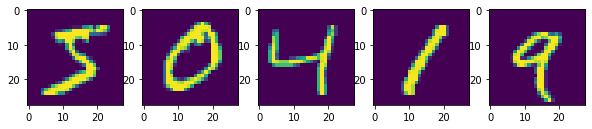

In [36]:
x = X_train[:5].to(device)
fig, axis = plt.subplots(ncols = 5, figsize = (10, 2))
for i in range(5):
    axis[i].imshow(x[i].cpu().detach().view(28, 28))

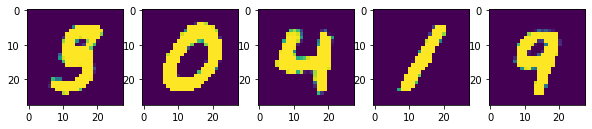

In [37]:
y = vae.decode(vae.encode(x)[0])
fig, axis = plt.subplots(ncols = 5, figsize = (10, 2))
for i in range(5):
    axis[i].imshow(y[i].cpu().detach().view(28, 28))

Let's look at the distribution in the latent space:

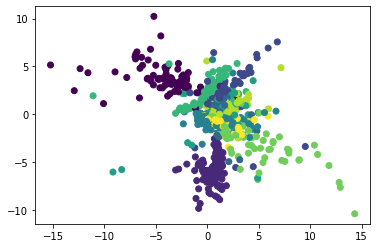

In [38]:
test = X_test[:1000].to(device)
labels = Y_test[:1000]
vecs = vae.encode(test)[0]
vecs = vecs.cpu().detach().numpy()
plt.scatter(vecs[:, 0], vecs[:, 1], c = labels.cpu().numpy())

Create and decode uniformal examples in latent space:

In [0]:
A = np.meshgrid(np.linspace(-20, 20, 35), np.linspace(-20, 20, 35))
z = torch.cat([torch.FloatTensor(A[0]).view(1, 35, 35), torch.FloatTensor(A[1]).view(1, 35, 35)], dim = 0).view(2, -1).t()

Compute uncertainty:

In [40]:
imgs = vae.decode(z.to(device))
unc3 = compute_uncertainty(model, imgs, 200)
unc3.mean()

0.3703911562731616

And finally let's look at the uncertainty distribution in the latent space:

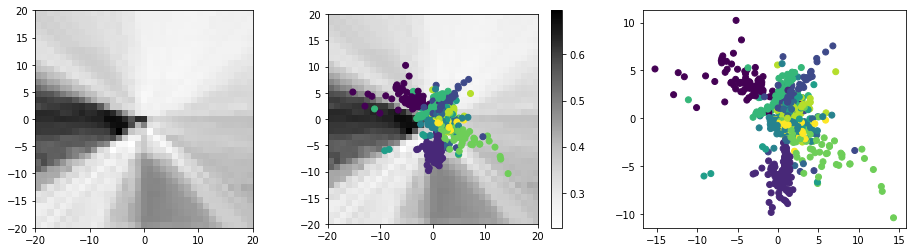

In [41]:
fig, axis = plt.subplots(ncols = 3, figsize = (16, 4))
im = axis[0].imshow(unc3.reshape(35, 35), extent=[-20,20,-20,20], cmap = 'Greys')
im = axis[1].imshow(unc3.reshape(35, 35), extent=[-20,20,-20,20], cmap = 'Greys')
axis[1].scatter(vecs[:, 0], vecs[:, 1], c = labels.cpu().numpy())
axis[2].scatter(vecs[:, 0], vecs[:, 1], c = labels.cpu().numpy())
fig.colorbar(im, ax = axis[1])